In [1]:
import update_db
import query_db
import calculate_returns
import calculate_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as statools

In [2]:
# Program config
db_path = '/miniconda3/envs/ccapm_regression/Code/ccapm_regression/yahoo_financials_daily.db' # path to the Database
price = 'adjclose' # can be 'adjclose' or 'close'
filter_zero_volume = False # filter stock prices where volume = 0, it is advised to set True


In [3]:
# querying all the tickers
all_tickers = query_db.get_all_available_stock_table(db_path)

# querying consumption
consumption_df = query_db.query_household_consumption_index(db_path)

#querying stock prices
stocks_prices_df = query_db.query_stock_prices(db_path, all_tickers, price, filter_zero_volume)

# calculating consumption returns
consumption_returns_df = calculate_returns.calculate_consumption_return(consumption_df)


# calculating stock returns
stocks_returns_df = calculate_returns.calculate_stock_returns_df(stocks_prices_df)

# calculating the regressions and extracting the residues
regression_dict, regression_residues_df = calculate_regression.calculate_linear_regression(stocks_returns_df,
                                                                                           consumption_returns_df)

# extracting the regression dataframe
regression_df = calculate_regression.generate_regression_dataframe(regression_dict)


# configuring the pandas display to show the entire dataframe
pd.options.display.max_rows = 999
pd.options.display.max_columns = 20


# Final Household Consumption Expediture

The Final Household Consumption Expediture (or just Household Consumption) consist of resident's household expenditure on goods and services. It is measured and published by Instituto Brasileiro de Geografia e Estatística - IBGE (Brazilian Institute of Geography and Statistics) every quarter and composes the aggregate demand as also highly correlated to the families' available income.

fonte: https://ww2.ibge.gov.br/home/estatistica/indicadores/pib/default_SCN_2010.shtm -  Notas metodológicas da nova série do Sistema de Contas Nacionais (SCN)


The Final Household Consumption Expenditure, which will also be called, in this paper, Consumption Index or Consumption, that is used in the model is measured using a Volume Index, issued quarterly by the IBGE, with the base date as 1995, being part of the Sistema de Contas Nacionais Trimestrais - SCNT (Quarterly National Accounting System). The serie is sazonaly adjusted by X13-ARIMA which possibilitates to calculate the viariation between consecutives quarters.

fonte: https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9300-contas-nacionais-trimestrais.html?=&t=o-que-e


The Brazillian economy was significantly impacted by the Plano Real, when the government was able to create a strong currency in the later 90s, putting and end to the strong inflation after a series of attempts in the 80s and 90s. The plan has not only changed the name of the currency, but also the structure of the economy.

Considering this important change in the Brazillian economy, we will be only using data starting in the beggining of the year 2000 or later. Also, it is crucial to clarify that the sole pourpose of this paper is the implementation of the Consumed Based Capital Asset Pricing Model and has no intention to search for the cause or consequence of any event that has happened.

If we observe the Consumption Index from 2000 to 2018 (the latest data point available at this time), it is possible to notice a upward trend, easily observable between the first quarter of 2004 to the end of 2014 in the graph below. To confirm, we will use the Agument Dickey-Fuller (ADF). 

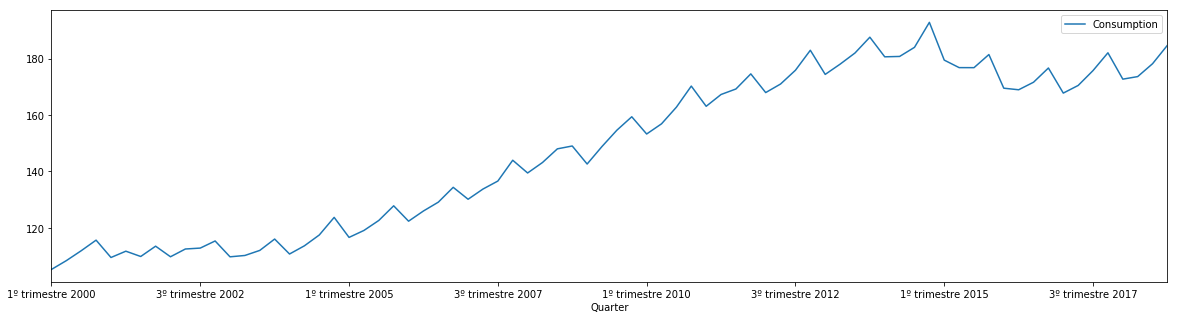

In [4]:
consumption_df.reset_index().plot(x='Quarter',y='Consumption', figsize=(20,5))

In [5]:
X = consumption_df.Consumption.values
result = statools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('LAGs: %i' % result[2])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.253889
LAGs: 9
p-value: 0.649995
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


If we look to the ADF results, we cannot reject the null hyphotesis, in other words, the time series is indeed, as previously observed, non stationary. It is also possible to notice that in the last quarter of every year, there is an increase in the consumption and a drop in the following quarter. To understand better this behavior, we will than decompose the Consumption Index.

ADF Statistic: -12.281626
LAGs: 1
p-value: 0.000000
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589


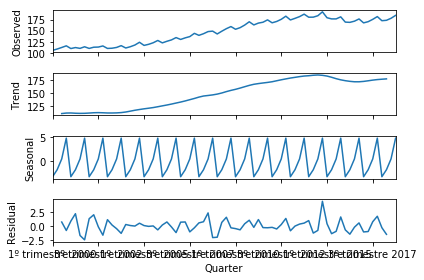

In [18]:
consumption_decompose = sm.tsa.seasonal_decompose(consumption_df,freq=4).plot()

X = sm.tsa.seasonal_decompose(consumption_df,freq=4).resid.dropna().Consumption.values
result = statools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('LAGs: %i' % result[2])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


In [106]:
#sm.tsa.seasonal_decompose(consumption_df,freq=4).trend.plot(figsize=(20,10)) # trend


In [107]:
#sm.tsa.seasonal_decompose(consumption_df,freq=4).seasonal.plot(figsize=(20,5)) # seasonality


In [108]:
#sm.tsa.seasonal_decompose(consumption_returns_df,freq=4).resid.plot(figsize=(20,5)) # resid

ADF Statistic: -4.864566
LAGs: 8
p-value: 0.000041
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590


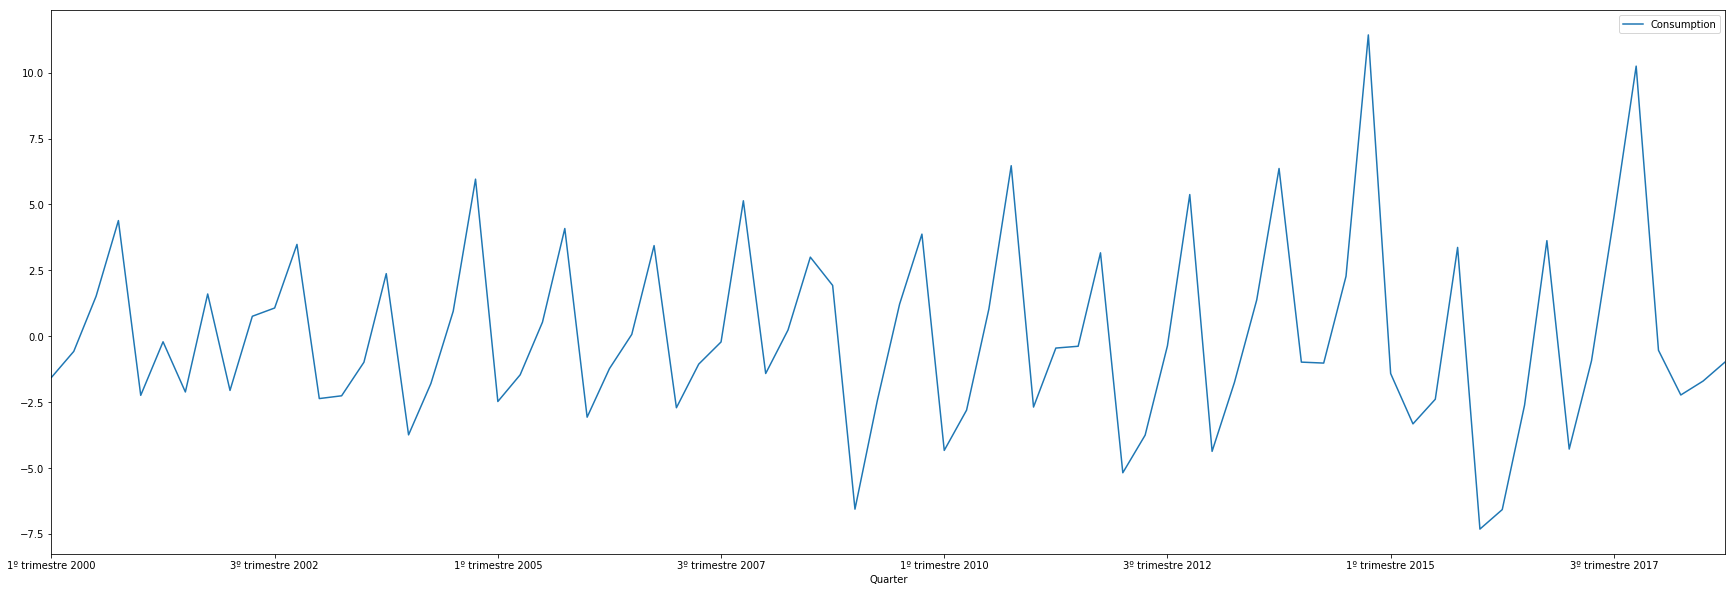

In [105]:
# Apenas retirando a tendencia
sm.tsa.tsatools.detrend(consumption_df,order=7).plot(figsize=(30,10))
X = sm.tsa.tsatools.detrend(consumption_df,order=7).Consumption.values
result = statools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('LAGs: %i' % result[2])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


For the implementation of the Consumed Based CAPM, we will use the return of the Consumption which will be estimated by Rct = ln(Ct/Ct-1). The serie has a mean of 0.007501 and a standard deviation of 0.033842. By observing the graphic, on a first look seems that it is stationary. The ADF test results, on the contrary, states that we cannot reject the null hypothesis that the time series has a unit root. In other words, the return of Consumption Index is non-stationary. To eliminate this non-stationarity, it is possible to use a polynomial of order four, which, if we use the ADF test in the residues, we than can reject the null hypothesys.

In [12]:
print('mean:', consumption_returns_df.mean().Consumption)
print('std:', consumption_returns_df.std().Consumption)

mean: 0.007501288348716931
std: 0.03384170904731816


ADF Statistic: -1.804608
LAGs: 8
p-value: 0.378177
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


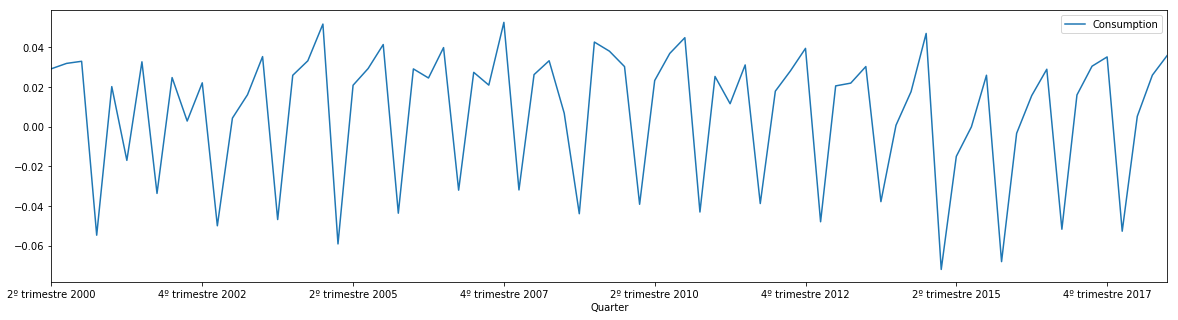

In [104]:
# return consumption index ADF
X = consumption_returns_df.Consumption.values
result = statools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('LAGs: %i' % result[2])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
# grafico consumption_returns_df
consumption_returns_df.reset_index().plot(x='Quarter',y='Consumption', figsize=(20,5))

ADF Statistic: -2.928778
LAGs: 8
p-value: 0.042102
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


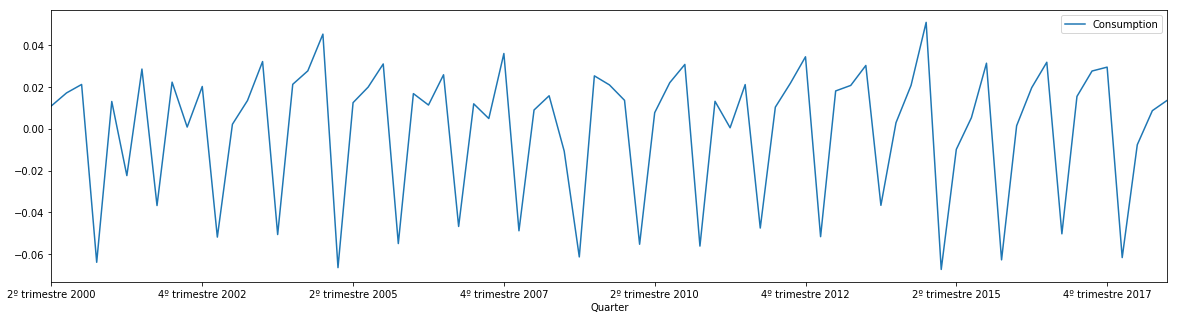

In [111]:
# consumption_return_df detrend
order_ = 4
X = sm.tsa.tsatools.detrend(consumption_returns_df, order = order_).dropna().Consumption.values
result = statools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('LAGs: %i' % result[2])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
sm.tsa.tsatools.detrend(consumption_returns_df,order = order_).plot(figsize=(20,5))


ADF Statistic: -7.861360
LAGs: 4
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


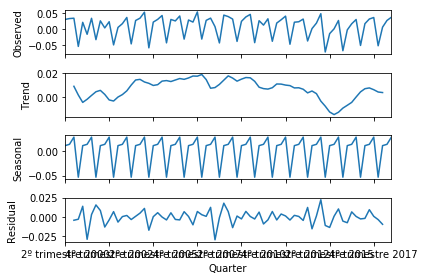

In [59]:
# consumption_return_df seasonal decompose
freq_=4
X = sm.tsa.seasonal_decompose(consumption_returns_df,freq=freq_).resid.dropna().Consumption.values
result = statools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('LAGs: %i' % result[2])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
consumption_returns_decompose = sm.tsa.seasonal_decompose(consumption_returns_df,freq=freq_).plot()

# Brazillian Stock Market - IBOVESPA

The Consumed Based CAPM used in here, states that the return of an asset would be a linear function of the consumption. We will be using in this work stocks of the Brazillian Stock Market that have more than 52 quarters (13 years) of price history due to the Consumption Index being realesed by IBGE quarterly.

The Ibovespa is the more important index of the Brazillian Stock Mark. It was created in 1968 and has became a reference for both national and international investors. It is theoretical portifolio composed by stocks and units that are exclusively listed at B3 (formerly Bovespa) and which meets the criteria stablished in its methodology. The main objective of the index is to be a indicator of the average performance of the most liquid assets negotiated in B3.

fonte: http://www.bmfbovespa.com.br/pt_br/produtos/indices/indices-amplos/indice-bovespa-ibovespa.htm

The index shows 3 big trends from the beggining of 2000 to the end of 2018. The first one is the Brazillian bull market starting at the end of 2002 that last for 6 years until the subprime mortage crisis in 2007/2008. With that shock, Ibovespa plumbed in less than five months, reaching its bottom around October 2008.

In the following 2 years, the Brazillian stock market regainned what had lost in the 2008 crisis. From the second semester of 2010 to 2016, the index drifted slowing decaying as the economy first stagnates and than has a  strong deterioration, culminating in one of the worst crisis that Brazil economy has ever experienced. In the first semester of 2016, after a lot of turmoil, it is protocolated the impeachement process against than president Dilma Rousseff.

After President Rousseff was formally removed from the office, her Vice President, Michael Temer sworn and became the new President of Brazil. Temer, being part of the Democratic Party, a more centric party and by teaming with Henrique Meirelles as his Minister of Finance and Ilan Goldfajn as the President of the Central Bank brought more confidence to the investors. During this time, from 2016 to the end of 2018, the Ibovespa index rose as the goverment started talks about structural reforms viwed with good eyes by the investors. During the 3 last quarters of 2018, the volatility of the market skyrocket due to the elections and the fear of the Workers Party comeback.


ADF Statistic: -1.535305
LAGs: 0
p-value: 0.515980
Critical Values:
	1%: -3.473
	5%: -2.880
	10%: -2.577


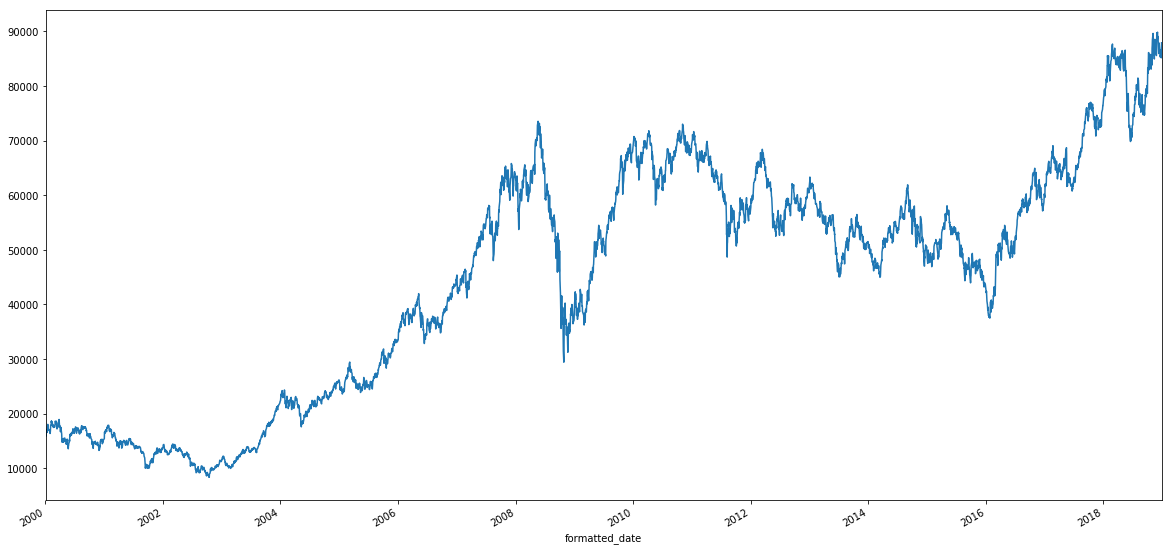

In [56]:
X = stocks_prices_df.dropna().Bovespa.values
result = statools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('LAGs: %i' % result[2])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
stocks_prices_df.Bovespa.dropna().plot(figsize=(20,10))


ADF Test

ADF Statistic: -4.679402
LAGs: 20
p-value: 0.000092
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


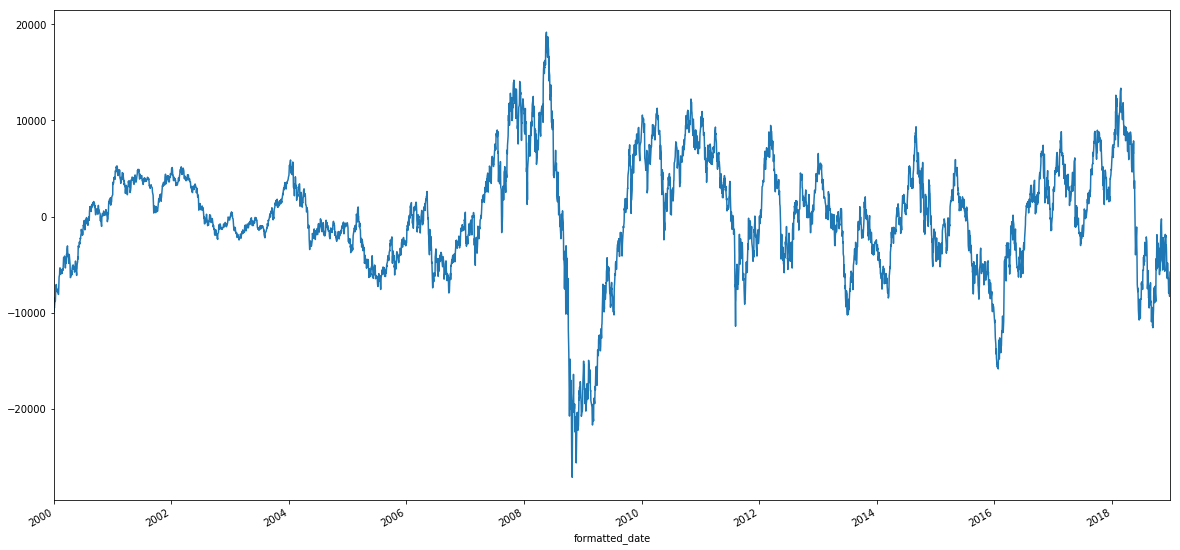

In [116]:
# Stock detrend
print('ADF Test')
print()
order_ = 4
X = sm.tsa.tsatools.detrend(stocks_prices_df.Bovespa.dropna(),order=order_).dropna().values
result = statools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('LAGs: %i' % result[2])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

    
sm.tsa.tsatools.detrend(stocks_prices_df.Bovespa.dropna(),order=order_).plot(figsize=(20,10))

For the implementation of the Consumed Based CAPM, we will use the return of the Consumption which will be estimated by Rct = ln(Ct/Ct-1). The serie has a mean of 0.015722 and a standard deviation of 0.12686. The ADF test results on the time series, on the contrary, states that we cannot reject the null hypothesis that the time series has a unit root. In other words, the return of Consumption Index is non-stationary. To eliminate this non-stationarity, it is possible to use a polynomial of order three, which, if we use the ADF test in the residues, we than can reject the null hypothesys.

To implement the Consumed Based CAPM, we will be using in the model, the quarterly returns of the Index, to match the timeframe of the Consumption Index. The return will be computed by Rb = ln(Pt /Pt-1). The serie has a mean of 0.015722 and a standard deviation of 0.12686. The ADF test results on the time series says that we can reject the null hypothesis, thus considering the series as stationary.

In [109]:
print('mean:', stocks_returns_df.Bovespa.mean())
print('std:', stocks_returns_df.Bovespa.std())

mean: 0.01572215558750297
std: 0.12686258917293022


ADF Statistic: -8.425832
LAGs: 0
p-value: 0.000000
Critical Values:
	1%: -3.521
	5%: -2.901
	10%: -2.588


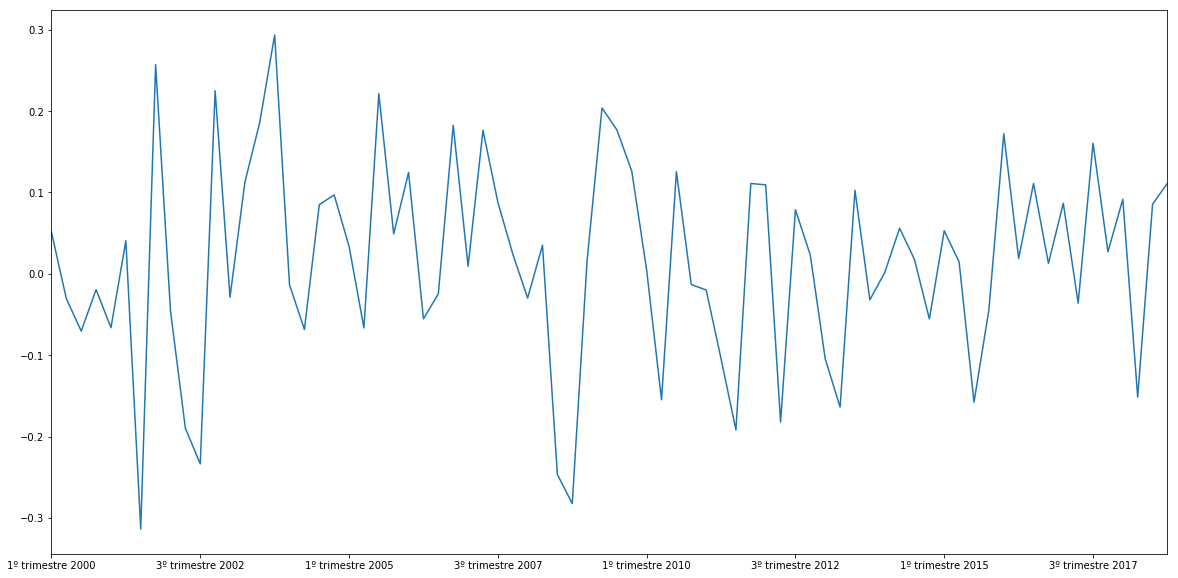

In [117]:
X = stocks_returns_df.Bovespa.values

result = statools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('LAGs: %i' % result[2])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
stocks_returns_df.Bovespa.dropna().plot(figsize=(20,10))
